# TAREA 1
#### ESTUDIANTES: Francisco Madariaga - Joaquín Valencia

### Pregunta 1) El set de datos 1 contiene información respecto a los estudiantes que han ingresado a la faculta de ingeniría. Se le pide que implemente una regresión logística que permita aprender a clasificar a que cluster pertenece cada alumno de acuerdo la información que se entrega. Recuerde que por convención la última columna del set de datos representa la señal que usted quiere aprender. También tenga en cuenta que las clases están desbalanceadas y que se espera que usted utilice 80% de los datos para entrenar y el 20% restante para testear. Además, presente una matriz de confusión y el f1-score. Finalmente, una restricción fuerte de este ejercicio es que todo debe estar programado en tensorflow 2 y desarrollado en Colab.

In [48]:
# Importando librerías para analizar el set de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando el dataset
data = pd.read_excel('dataset1.xlsx')

In [49]:
#Revisando cómo se ve nuestro dataset
data.head()

,crr_Nom,psu_Nem,psu_Leng,psu_Mate,psu_Cie,psu_Pond,Longitud,Latitud,cred_apr,distancia,F,M,PARTICULAR_SUBVENCIONADO,PARTICULAR_PAGADO,MUNICIPAL,cluster
0,INGENIERIA CIVIL INDUSTRIAL,783,653,685,672,735,-73.16487,-36.978759,38,20.201244,1,0,1,0,0,C2
1,INGENIERIA CIVIL BIOMEDICA,799,705,713,686,756,-73.16487,-36.978759,36,20.201244,1,0,1,0,0,C1
2,INGENIERIA CIVIL QUIMICA,688,543,612,534,638,-73.16487,-36.978759,36,20.201244,1,0,1,0,0,C3
3,INGENIERIA CIVIL ELECTRICA,605,598,658,601,633,-73.16487,-36.978759,21,20.201244,0,1,1,0,0,C2
4,INGENIERIA CIVIL INFORMATICA,603,710,668,651,657,-73.16487,-36.978759,19,20.201244,0,1,1,0,0,C2


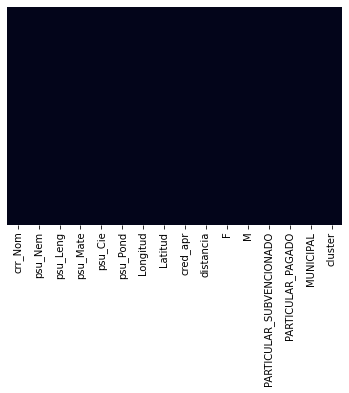

In [52]:
# ¿Faltan datos en alguna columna de nuestro dataset?
sns.heatmap(data.isnull(),yticklabels=False,cbar=False)

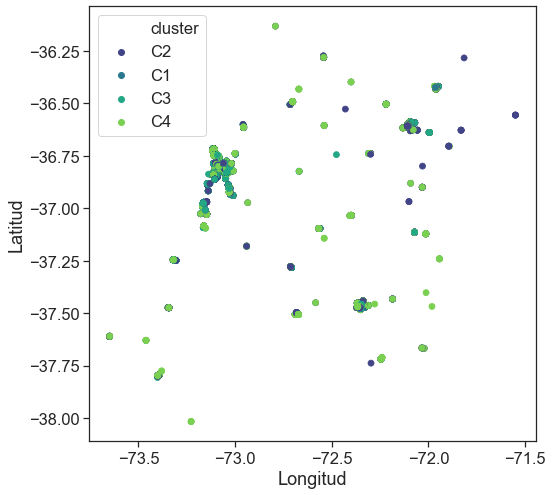

In [168]:
#¿Hay alguna correlación visible entre clusters y la localización de los estudiantes?
plt.figure(figsize=(8,8))
sns.scatterplot(x='Longitud',y='Latitud',data=data,hue='cluster',edgecolor=None,palette='viridis',legend='brief')

In [146]:
# Obteniendo nuestras matrices para el modelo
y = data['cluster']
X = data.drop(['cluster'],axis=1)

Para preparar la matriz X, es importante notar que hay varias variables binarias que hay que eliminar, dado que ambas presentan multicolinearidad perfecta. Este es el caso de 'F' y 'M', o 'PARTICULAR_SUBVENCIONADO', 'PARTICULAR_PAGADO' y 'MUNICIPAL'.

Para solucionar este problema, solamente eliminaremos una variable que le permita al modelo entender la caracterización que tratamos de representar con las variables. Es decir, si dejamos 'M', el modelo ya puede saber si la persona es Hombre o Mujer (1 = Hombre, 0 = Mujer). De la misma manera, podemos dejar solo 2 de las 3 variables que se relacionan con la educación secundaria de la persona.

El criterio a utilizar para determinar qué variables quedarán, son las que tienen mayor presencia en nuestros datos. (Ej: Hay más Hombres que Mujeres)

Además, hay ocasiones en que una variable compuesta por texto se elimine de la estimación, ya que no es numérica. Pero para este caso haremos uso de la información que contiene al hacer uso de variables Dummy para representar a qué carrera pertenece el estudiante.



In [147]:
y = pd.get_dummies(data['cluster'])
X = X.join(pd.get_dummies(X['crr_Nom']))
X = X.drop(['F','MUNICIPAL','INGENIERIA CIVIL AEROESPACIAL','crr_Nom'],axis=1)

#Transformando los DataFrames a Numpy-Arrays
X = X.values
y = y.values

In [148]:
# Importando librerías para construir el modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [149]:
# Creando los sets de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [150]:
# Creando el modelo
model = Sequential()

# Input Layer
model.add(Dense(16, activation='sigmoid'))

# Hidden Layers
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))

# Ouput Layer
model.add(Dense(4,activation='softmax'))

# Compiler
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['categorical_accuracy'])

# Ajustando el modelo
model.fit(x=X_train,y=y_train,epochs=500,verbose=False)

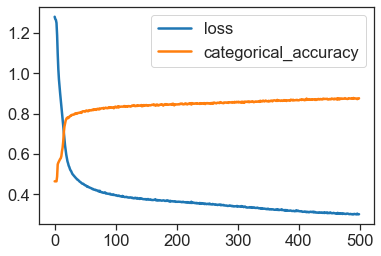

In [164]:
# Graficando la pérdida del modelo y el Categorical Accuracy.
losses = pd.DataFrame(model.history.history)
losses.plot()

In [170]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

def to_which_category(coef):
    one_hot = np.zeros(coef.shape)
    coef_np = coef.values
    for i in range(coef.shape[0]):
        one_hot[i][np.argmax(coef_np[i])] = 1
    one_hot = pd.DataFrame(one_hot)
    return one_hot
    
def how_many(one_hot):
    return one_hot.sum()

# Entregandole los datos de prueba al modelo ajustado.
prediction = pd.DataFrame(model.predict(X_test))

# Determinando qué categorías predijo el modelo.
categorized = to_which_category(prediction)

### Al evaluar un modelo se pueden utilizar diversas métricas. En este caso haremos uso de 2; el f1-score y la confusion matrix.

##### El f1-score es la media harmónica entre el precision score y el recall score. Ambas métricas entregan información valiosa para determinar si nuestro modelo está entregando buenos resultados o no.

$$f_{1} score = \frac{2}{{precision^{-1}} + {recall^{-1}}} =2 * \frac{precision * recall}{precision + recall}$$

El Precision score se interpreta como la proporción de Positivos verdaderos entre todos los positivos que estimó el modelo, sean verdaderos o falsos.

$ Precision_{score} = \frac{True Positives}{True Positives + False Positives}$


El Recall score se interpreta como la proporción de Positivos verdaderos entre todos los realmente positivos (positivos verdaderos + falsos negativos).

$ Recall_{score} = \frac{True Positives}{True Positives + False Negatives}$

In [171]:
print(classification_report(y_test,categorized))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       287
           1       0.88      0.85      0.86       708
           2       0.80      0.83      0.81       361
           3       0.80      0.78      0.79       218

   micro avg       0.84      0.84      0.84      1574
   macro avg       0.83      0.84      0.84      1574
weighted avg       0.84      0.84      0.84      1574
 samples avg       0.84      0.84      0.84      1574



Los 3 scores que comentamos anteriormente tienen un valor entre 0 y 1, siendo 1 el mayor valor que pueden tomar.
En este caso nos interesa el f1-score, los cuales presentan valores aceptables para las 4 categorías de estudio.

### Por otro lado, la confusion matrix nos permite visualizar qué tan bien está prediciendo nuestro modelo en términos de True Positives, False Positives, True Negatives, False Negatives. La forma en que se lee una confusion matrix es la siguiente.

<img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" width="400" height="400" />

En este caso, como tenemos un problema de multiclases excluyentes, veremos una confusion matrix para cada clase. Estas se presentan a continuación

In [191]:
print(multilabel_confusion_matrix(y_test,categorized))

[[[1245   42]
  [  29  258]]

 [[ 782   84]
  [ 108  600]]

 [[1136   77]
  [  60  301]]

 [[1313   43]
  [  49  169]]]


Como podemos observar, en las categorías C1, C3 y C4 está clasificando relativamente bien. Mientras que en la categoría C2 hay una gran cantidad de Falsos Negativos y Falsos positivos, lo que está afectando directamente a los scores anteriormente mencionados y nos permite ver que la predicción del modelo podría ser mejor.

## Prueba 2

#### Eliminando todas las variables que podrían presentar algún problema, simplificando el modelo para tratar de ver si puede predecir algo medianamente lógico, o aumentar el accuracy de la predicción

In [ ]:
y2 = data['cluster']
X2 = data.drop('cluster',axis=1)

In [ ]:
X2.drop(['crr_Nom','Longitud','Latitud','F','MUNICIPAL'],axis=1,inplace=True)

In [ ]:
X2.head()

In [ ]:
y2 = y2.astype('category')
y2 = y2.cat.codes
y2 = y2.values
X2 = X2.values

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

In [ ]:
# Creando el modelo
model2 = Sequential()

model2.add(Dense(25, activation='sigmoid'))
model2.add(Dense(25, activation='sigmoid'))
model2.add(Dense(25, activation='sigmoid'))

model2.add(Dense(4,activation='softmax'))

model2.compile(optimizer='sgd',loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model2.fit(x=X2_train,y=y2_train,epochs=200,verbose=False)

In [ ]:
pred = model2.predict(X2_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y2_test)

w = pd.DataFrame(pred)
w['real'] = y2_test
w['accuracy'] = w[0] == w['real']
print((w['accuracy'].sum() / w.shape[0] )*100)

## Prueba 3

### intentándolo con tensorflow puro

In [35]:
#Declaring necessary modules
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
tf.autograph.set_verbosity(2)

# Declare the inputs
x = tf.constant(X_train, dtype=tf.float64, name='x')
y = tf.constant(y_train, dtype=tf.float64, name='cluster')


In [42]:
class Model(object):
    def __init__(self):
        samples, features = (X_train.shape[0],X_train.shape[1]) #x.shape
        hidden1_nodes = 4
        hidden2_nodes = 4
        self.theta1 = tf.Variable(tf.random.normal([features+1,hidden1_nodes], dtype= tf.float64) ,name = "Theta1")
        self.theta2 = tf.Variable(tf.random.normal([hidden1_nodes+1,hidden2_nodes], dtype= tf.float64), name = "Theta2")

    def __call__(self, x):
        bias1 = tf.constant(1, shape=(X_train.shape[0],1), dtype=tf.float64, name='bias1')
        bias2 = tf.constant(1, shape=(X_train.shape[0],1), dtype=tf.float64, name='bias2')
        a0 = tf.concat([bias1,x],1, name='a0')
        z1 = tf.matmul(a0,self.theta1, name='z1')
        a1 = tf.concat([bias2,tf.sigmoid(z1)],1,name='a1')
        z2 = tf.matmul(a1,self.theta2, name='z2')
        a2 = tf.nn.softmax(z2, name='a2')
        return a2

def loss(target_y, predicted_y):
    return -tf.reduce_sum(target_y*tf.math.log(predicted_y)+(1-target_y)*tf.math.log(1-predicted_y), axis = 0, name='Cost_function')
    
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dThe1, dThe2 = t.gradient(current_loss, [model.theta1, model.theta2])
    model.theta1.assign_sub(learning_rate * dThe1)
    model.theta2.assign_sub(learning_rate * dThe2)
    
#%% [markdown]
### Optimize
    
#%%
model = Model()
theta1_hist, theta2_hist = [], []
for epoch in range(60):
    current_loss = loss(y, model(x))
    learning_rate = 0.05
    train(model, x, y, learning_rate=learning_rate)
    if epoch % 100 == 0:
        theta1_hist.append(model.theta1.numpy())
        theta2_hist.append(model.theta2.numpy())

AttributeError: 'Model' object has no attribute 'Theta1'

TensorShape([6292, 4])